# **Sentiment Analysis** of the **Reviews** from **YELP** Dataset


## **MODEL 1 - BERT**

#### Install Transformers

In [1]:
!pip install transformers

#### Install langdetect

In [32]:
!pip install langdetect

#### Mounting Drive - (Google collab was used)

In [33]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### Importing the necessary libraries

In [34]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import rc
from pylab import rcParams
import matplotlib.pyplot as plt
from textwrap import wrap
from collections import defaultdict
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score,f1_score,precision_score, recall_score

import re
import spacy
sp = spacy.load('en_core_web_sm')

import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize

import transformers
from transformers import BertModel, BertTokenizer, BertForSequenceClassification
from transformers import AdamW, get_linear_schedule_with_warmup

import torch
from torch import nn,optim
from torch.utils.data import Dataset,DataLoader,TensorDataset, RandomSampler, SequentialSampler
import torch.nn as nn
import torch.nn.functional as F
device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

import time
import datetime

import tensorflow as tf

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid',palette='muted',font_scale=1.2)
color_palette=['#01BEFE','#FFDD00','#FF7D00','#FF006D','#ADFF02','#8F00FF']
sns.set_palette(sns.color_palette(color_palette))

rcParams['figure.figsize']= 10,5

seed=42
np.random.seed(seed)
torch.manual_seed(seed)

import sys
import os
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore"

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


#### Importing the review dataset and reading the first 10000 rows (heavy memory is consumed to read the full dataset)

In [35]:
#path is directed to google drive
df = pd.read_json('/content/drive/MyDrive/yelp_academic_dataset_review.json', nrows=10000, lines=True)

In [36]:
df.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3,0,0,0,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11
1,BiTunyQ73aT9WBnpR9DZGw,OyoGAe7OKpv6SyGZT5g77Q,7ATYjTIgM3jUlt4UM3IypQ,5,1,0,1,I've taken a lot of spin classes over the year...,2012-01-03 15:28:18
2,saUsX_uimxRlCVr67Z4Jig,8g_iMtfSiwikVnbP2etR0A,YjUWPpI6HXG530lwP-fb2A,3,0,0,0,Family diner. Had the buffet. Eclectic assortm...,2014-02-05 20:30:30
3,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5,1,0,1,"Wow! Yummy, different, delicious. Our favo...",2015-01-04 00:01:03
4,Sx8TMOWLNuJBWer-0pcmoA,bcjbaE6dDog4jkNY91ncLQ,e4Vwtrqf-wpJfwesgvdgxQ,4,1,0,1,Cute interior and owner (?) gave us tour of up...,2017-01-14 20:54:15


#### Dropping the columns that wont be needed

In [37]:
cols_to_drop = ['review_id', 'user_id', 'useful', 'funny', 'cool', 'date']
df.drop(cols_to_drop, axis=1, inplace=True)

In [45]:
df.head()

,business_id,stars,text
0,XQfwVwDr-v0ZS3_CbbE5Xw,3,"If you decide to eat here, just be aware it is..."
1,7ATYjTIgM3jUlt4UM3IypQ,5,I've taken a lot of spin classes over the year...
2,YjUWPpI6HXG530lwP-fb2A,3,Family diner. Had the buffet. Eclectic assortm...
3,kxX2SOes4o-D3ZQBkiMRfA,5,"Wow! Yummy, different, delicious. Our favo..."
4,e4Vwtrqf-wpJfwesgvdgxQ,4,Cute interior and owner (?) gave us tour of up...


#### **Importing** the **business** dataset

In [46]:
#google drive path
df1 = pd.read_json('/content/drive/MyDrive/yelp_academic_dataset_business.json', lines=True)

In [47]:
df1.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,Pns2l4eNsfO8kk83dixA6A,"Abby Rappoport, LAC, CMQ","1616 Chapala St, Ste 2",Santa Barbara,CA,93101,34.426679,-119.711197,5.0,7,0,{'ByAppointmentOnly': 'True'},"Doctors, Traditional Chinese Medicine, Naturop...",None
1,mpf3x-BjTdTEA3yCZrAYPw,The UPS Store,87 Grasso Plaza Shopping Center,Affton,MO,63123,38.551126,-90.335695,3.0,15,1,{'BusinessAcceptsCreditCards': 'True'},"Shipping Centers, Local Services, Notaries, Ma...","{'Monday': '0:0-0:0', 'Tuesday': '8:0-18:30', ..."
2,tUFrWirKiKi_TAnsVWINQQ,Target,5255 E Broadway Blvd,Tucson,AZ,85711,32.223236,-110.880452,3.5,22,0,"{'BikeParking': 'True', 'BusinessAcceptsCredit...","Department Stores, Shopping, Fashion, Home & G...","{'Monday': '8:0-22:0', 'Tuesday': '8:0-22:0', ..."
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,1,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","Restaurants, Food, Bubble Tea, Coffee & Tea, B...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ..."
4,mWMc6_wTdE0EUBKIGXDVfA,Perkiomen Valley Brewery,101 Walnut St,Green Lane,PA,18054,40.338183,-75.471659,4.5,13,1,"{'BusinessAcceptsCreditCards': 'True', 'Wheelc...","Brewpubs, Breweries, Food","{'Wednesday': '14:0-22:0', 'Thursday': '16:0-2..."


#### dataset is filtered for entries that contain restaurant reviews

In [48]:
df1 = df1[df1['categories'].notnull()]
df_rest = df1[df1['categories'].str.contains('Restaurant')]

In [49]:
df_rest = df_rest[['business_id', 'categories']]

In [50]:
df_rest.head()

,business_id,categories
3,MTSW4McQd7CbVtyjqoe9mw,"Restaurants, Food, Bubble Tea, Coffee & Tea, B..."
5,CF33F8-E6oudUQ46HnavjQ,"Burgers, Fast Food, Sandwiches, Food, Ice Crea..."
8,k0hlBqXX-Bt0vf1op7Jr1w,"Pubs, Restaurants, Italian, Bars, American (Tr..."
9,bBDDEgkFA1Otx9Lfe7BZUQ,"Ice Cream & Frozen Yogurt, Fast Food, Burgers,..."
11,eEOYSgkmpB90uNA7lDOMRA,"Vietnamese, Food, Restaurants, Food Trucks"


#### Both the datasets are merged on business-id

In [51]:
df_merged = df.merge(df_rest, how='inner', on='business_id')

In [52]:
del df, df_rest

In [54]:
df_merged.head()

,business_id,stars,text,categories
0,XQfwVwDr-v0ZS3_CbbE5Xw,3,"If you decide to eat here, just be aware it is...","Restaurants, Breakfast & Brunch, Food, Juice B..."
1,XQfwVwDr-v0ZS3_CbbE5Xw,2,This is the second time we tried turning point...,"Restaurants, Breakfast & Brunch, Food, Juice B..."
2,XQfwVwDr-v0ZS3_CbbE5Xw,4,The place is cute and the staff was very frien...,"Restaurants, Breakfast & Brunch, Food, Juice B..."
3,XQfwVwDr-v0ZS3_CbbE5Xw,3,We came on a Saturday morning after waiting a ...,"Restaurants, Breakfast & Brunch, Food, Juice B..."
4,YjUWPpI6HXG530lwP-fb2A,3,Family diner. Had the buffet. Eclectic assortm...,"Restaurants, Breakfast & Brunch"


In [55]:
# Rename the text column to restaurant_reviews
df_merged.rename(columns={'text':'restaurant_reviews'}, inplace=True)

#drop the business-id column
df_merged.drop('business_id', axis=1, inplace=True)

In [56]:
#this import is used in this project to select only the english reviews
from langdetect import detect

In [57]:
df_merged['detect'] = df_merged['restaurant_reviews'].apply(detect)
df_merged = df_merged[df_merged['detect'] == 'en'].reset_index(drop=True)

In [59]:
# Check if there is NaN values
df_merged.isnull().values.any()

False

In [60]:
df_merged.drop_duplicates(inplace=True)

#### 3 star reviews are removed - neutral

In [61]:
df_merged = df_merged[(df_merged["stars"]!=3)]
df_merged.head(20)

,stars,restaurant_reviews,categories,detect
1,2,This is the second time we tried turning point...,"Restaurants, Breakfast & Brunch, Food, Juice B...",en
2,4,The place is cute and the staff was very frien...,"Restaurants, Breakfast & Brunch, Food, Juice B...",en
5,5,"Wow! Yummy, different, delicious. Our favo...","Halal, Pakistani, Restaurants, Indian",en
6,2,Dine-in gets 2 stars. Disappointing service & ...,"Halal, Pakistani, Restaurants, Indian",en
7,5,After a long hiatus from reviewing I have awak...,"Halal, Pakistani, Restaurants, Indian",en
8,5,We've eaten here 3 times and it seems that eac...,"Halal, Pakistani, Restaurants, Indian",en
9,5,Came to Philly for a family event but stayed a...,"Halal, Pakistani, Restaurants, Indian",en
10,5,A very neat little hole in the wall. Very clea...,"Halal, Pakistani, Restaurants, Indian",en
11,4,This place was a great find. I'd say its a 4.5...,"Halal, Pakistani, Restaurants, Indian",en
12,4,I've been here several times. The price is rea...,"Halal, Pakistani, Restaurants, Indian",en


#### Label reviews as positive and negative

In [62]:
df_merged.loc[df_merged['stars'] < 3, 'sentiment'] = 0
df_merged.loc[df_merged['stars'] > 3, 'sentiment'] = 1

#remove the 'star' column
df_merged.drop('stars', axis=1, inplace=True)
df_merged.head(10)

,restaurant_reviews,categories,detect,sentiment
1,This is the second time we tried turning point...,"Restaurants, Breakfast & Brunch, Food, Juice B...",en,0.0
2,The place is cute and the staff was very frien...,"Restaurants, Breakfast & Brunch, Food, Juice B...",en,1.0
5,"Wow! Yummy, different, delicious. Our favo...","Halal, Pakistani, Restaurants, Indian",en,1.0
6,Dine-in gets 2 stars. Disappointing service & ...,"Halal, Pakistani, Restaurants, Indian",en,0.0
7,After a long hiatus from reviewing I have awak...,"Halal, Pakistani, Restaurants, Indian",en,1.0
8,We've eaten here 3 times and it seems that eac...,"Halal, Pakistani, Restaurants, Indian",en,1.0
9,Came to Philly for a family event but stayed a...,"Halal, Pakistani, Restaurants, Indian",en,1.0
10,A very neat little hole in the wall. Very clea...,"Halal, Pakistani, Restaurants, Indian",en,1.0
11,This place was a great find. I'd say its a 4.5...,"Halal, Pakistani, Restaurants, Indian",en,1.0
12,I've been here several times. The price is rea...,"Halal, Pakistani, Restaurants, Indian",en,1.0


#### checking for dataset imbalance

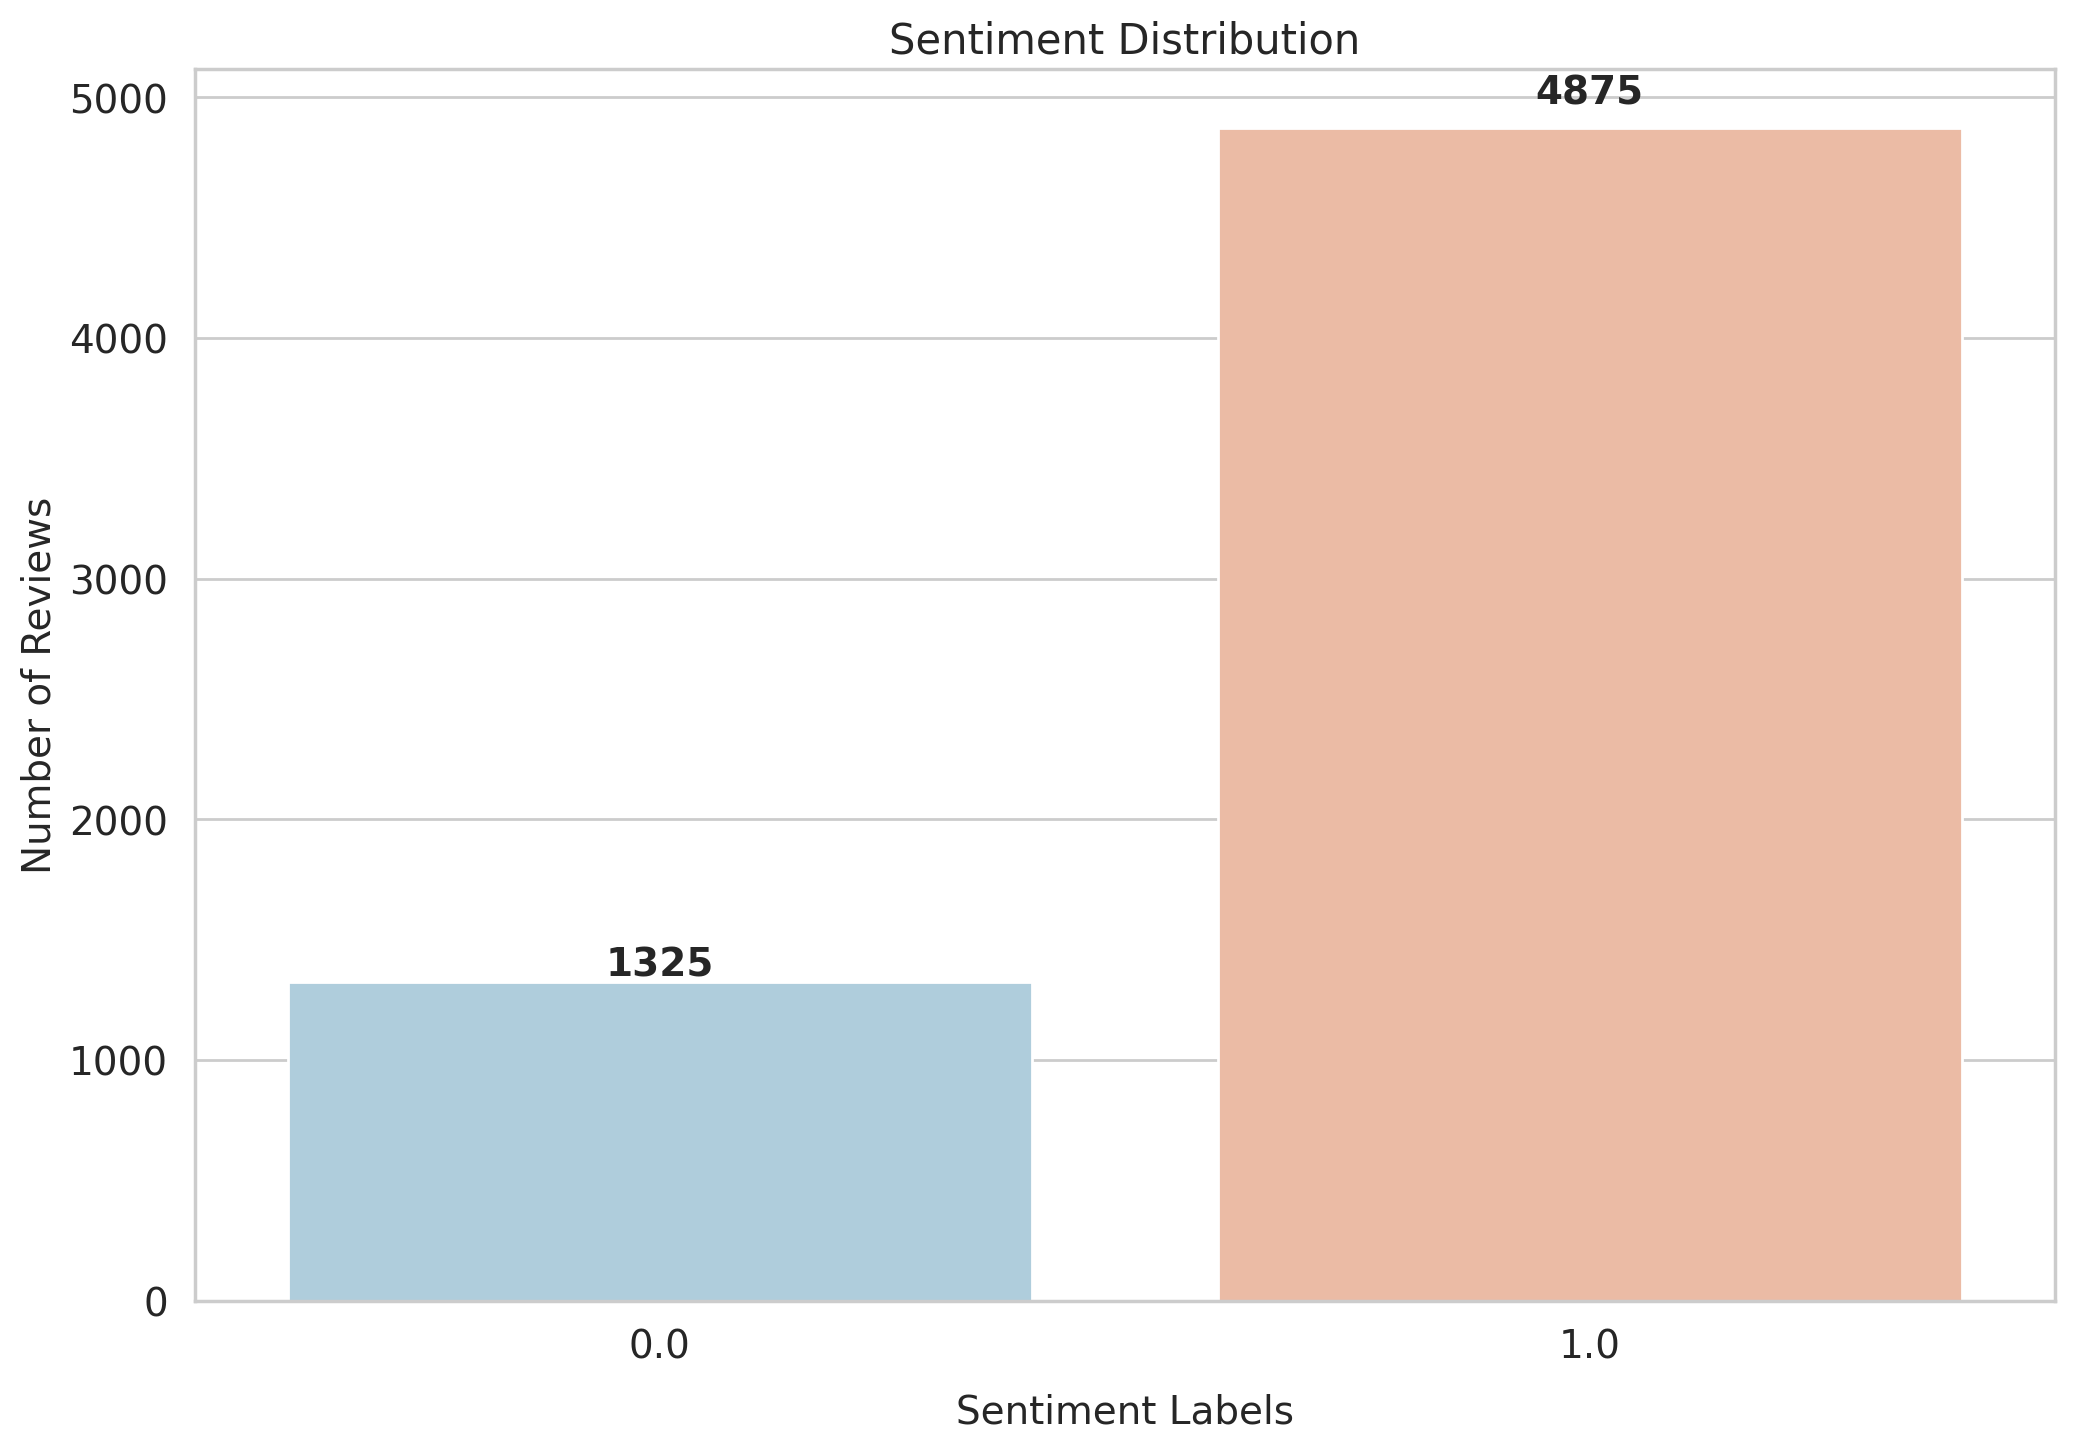

In [63]:
warnings.simplefilter(action='ignore', category=FutureWarning)

plt.figure(figsize=(12, 8))

grouped = df_merged.sentiment.value_counts().sort_index()
sns.barplot(x=grouped.index, y=grouped.values, palette=sns.color_palette("RdBu_r", len(grouped)))

plt.xlabel('Sentiment Labels', labelpad=10, fontsize=14)
plt.ylabel('Number of Reviews', fontsize=14)
plt.title('Sentiment Distribution', fontsize=15)
plt.tick_params(labelsize=14)

for i, v in enumerate(grouped):
    plt.text(i, v * 1.02, str(v), horizontalalignment='center', fontweight='bold', fontsize=14)

plt.show()


#### Upsampling is done to the negative class(0)

In [64]:
from sklearn.utils import resample

df_majority = df_merged[(df_merged['sentiment']==1)]
df_minority = df_merged[(df_merged['sentiment']==0)]


df_minority_upsampled = resample(df_minority,
                                 replace=True,
                                 n_samples= 4643, 
                                 random_state=42)
# Combine majority class with upsampled minority class
df_final = pd.concat([df_minority_upsampled, df_majority])

In [65]:
df_final.sentiment.value_counts()

1.0    4875
0.0    4643
Name: sentiment, dtype: int64

#### Removing stopwords with spaCy

In [66]:
sp = spacy.load('en_core_web_sm')
stopwords = sp.Defaults.stop_words

#'no' and 'not' are excluded as they affect the meaning of the review
exclude_stopwords = ['no','not']
for word in exclude_stopwords:
    stopwords.remove(word)

#### function for text processing

In [67]:
def text_preprocessing( raw_review ):
    # 1. Remove non-letters
    review_text_letters_only = re.sub("[^a-zA-Z]", " ", raw_review)
    # 2. Convert to lower case
    review_preprocessed = review_text_letters_only.lower()
    # 3. Word tokenization
    review_tokens = word_tokenize(review_preprocessed)
    # 4. Filter the stopwords
    filtered_sentence =[]
    for word in review_tokens:
        lexeme = sp.vocab[word]
        if lexeme.is_stop == False:
            filtered_sentence.append(word)

    return " ".join(filtered_sentence)

In [68]:
df_final['cleaned_reviews'] = df_final['restaurant_reviews'].apply(text_preprocessing)

In [69]:
df = df_final.reset_index(drop=True)

In [70]:
df.head()

,restaurant_reviews,categories,detect,sentiment,cleaned_reviews
0,This was by far the worst dinner I have ever h...,"Pizza, Restaurants, Italian",en,0.0,far worst dinner ate meatballs pasta pizza sau...
1,Ordered from grubhub waited an hour and a half...,"Food Delivery Services, Halal, Food, Restauran...",en,0.0,ordered grubhub waited hour half delivery call...
2,It was... not good. We got there late-ish on ...,"American (New), Vegetarian, Restaurants, Burgers",en,0.0,good got late ish sunday service obvious cared...
3,"The food is great, but I just waited 20 minute...","American (Traditional), Breakfast & Brunch, Re...",en,0.0,food great waited minutes carry order called c...
4,"Worst customer service ever, food is par by fa...","Restaurants, Pizza",en,0.0,worst customer service food par far dirty tabl...


## Sentiment analysis of YELP restaurant reviews with BERT in PyTorch

In [71]:
pre_trained_model='bert-base-uncased'

#### Splitting the reviews to tokens, to feed it into the model

In [72]:
#load the BERT tokenizer
tokenizer=BertTokenizer.from_pretrained(pre_trained_model)

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [73]:
token_lens = []

for txt in df.cleaned_reviews:
  tokens = tokenizer.encode(txt, max_length=512, truncation=True)
  token_lens.append(len(tokens))

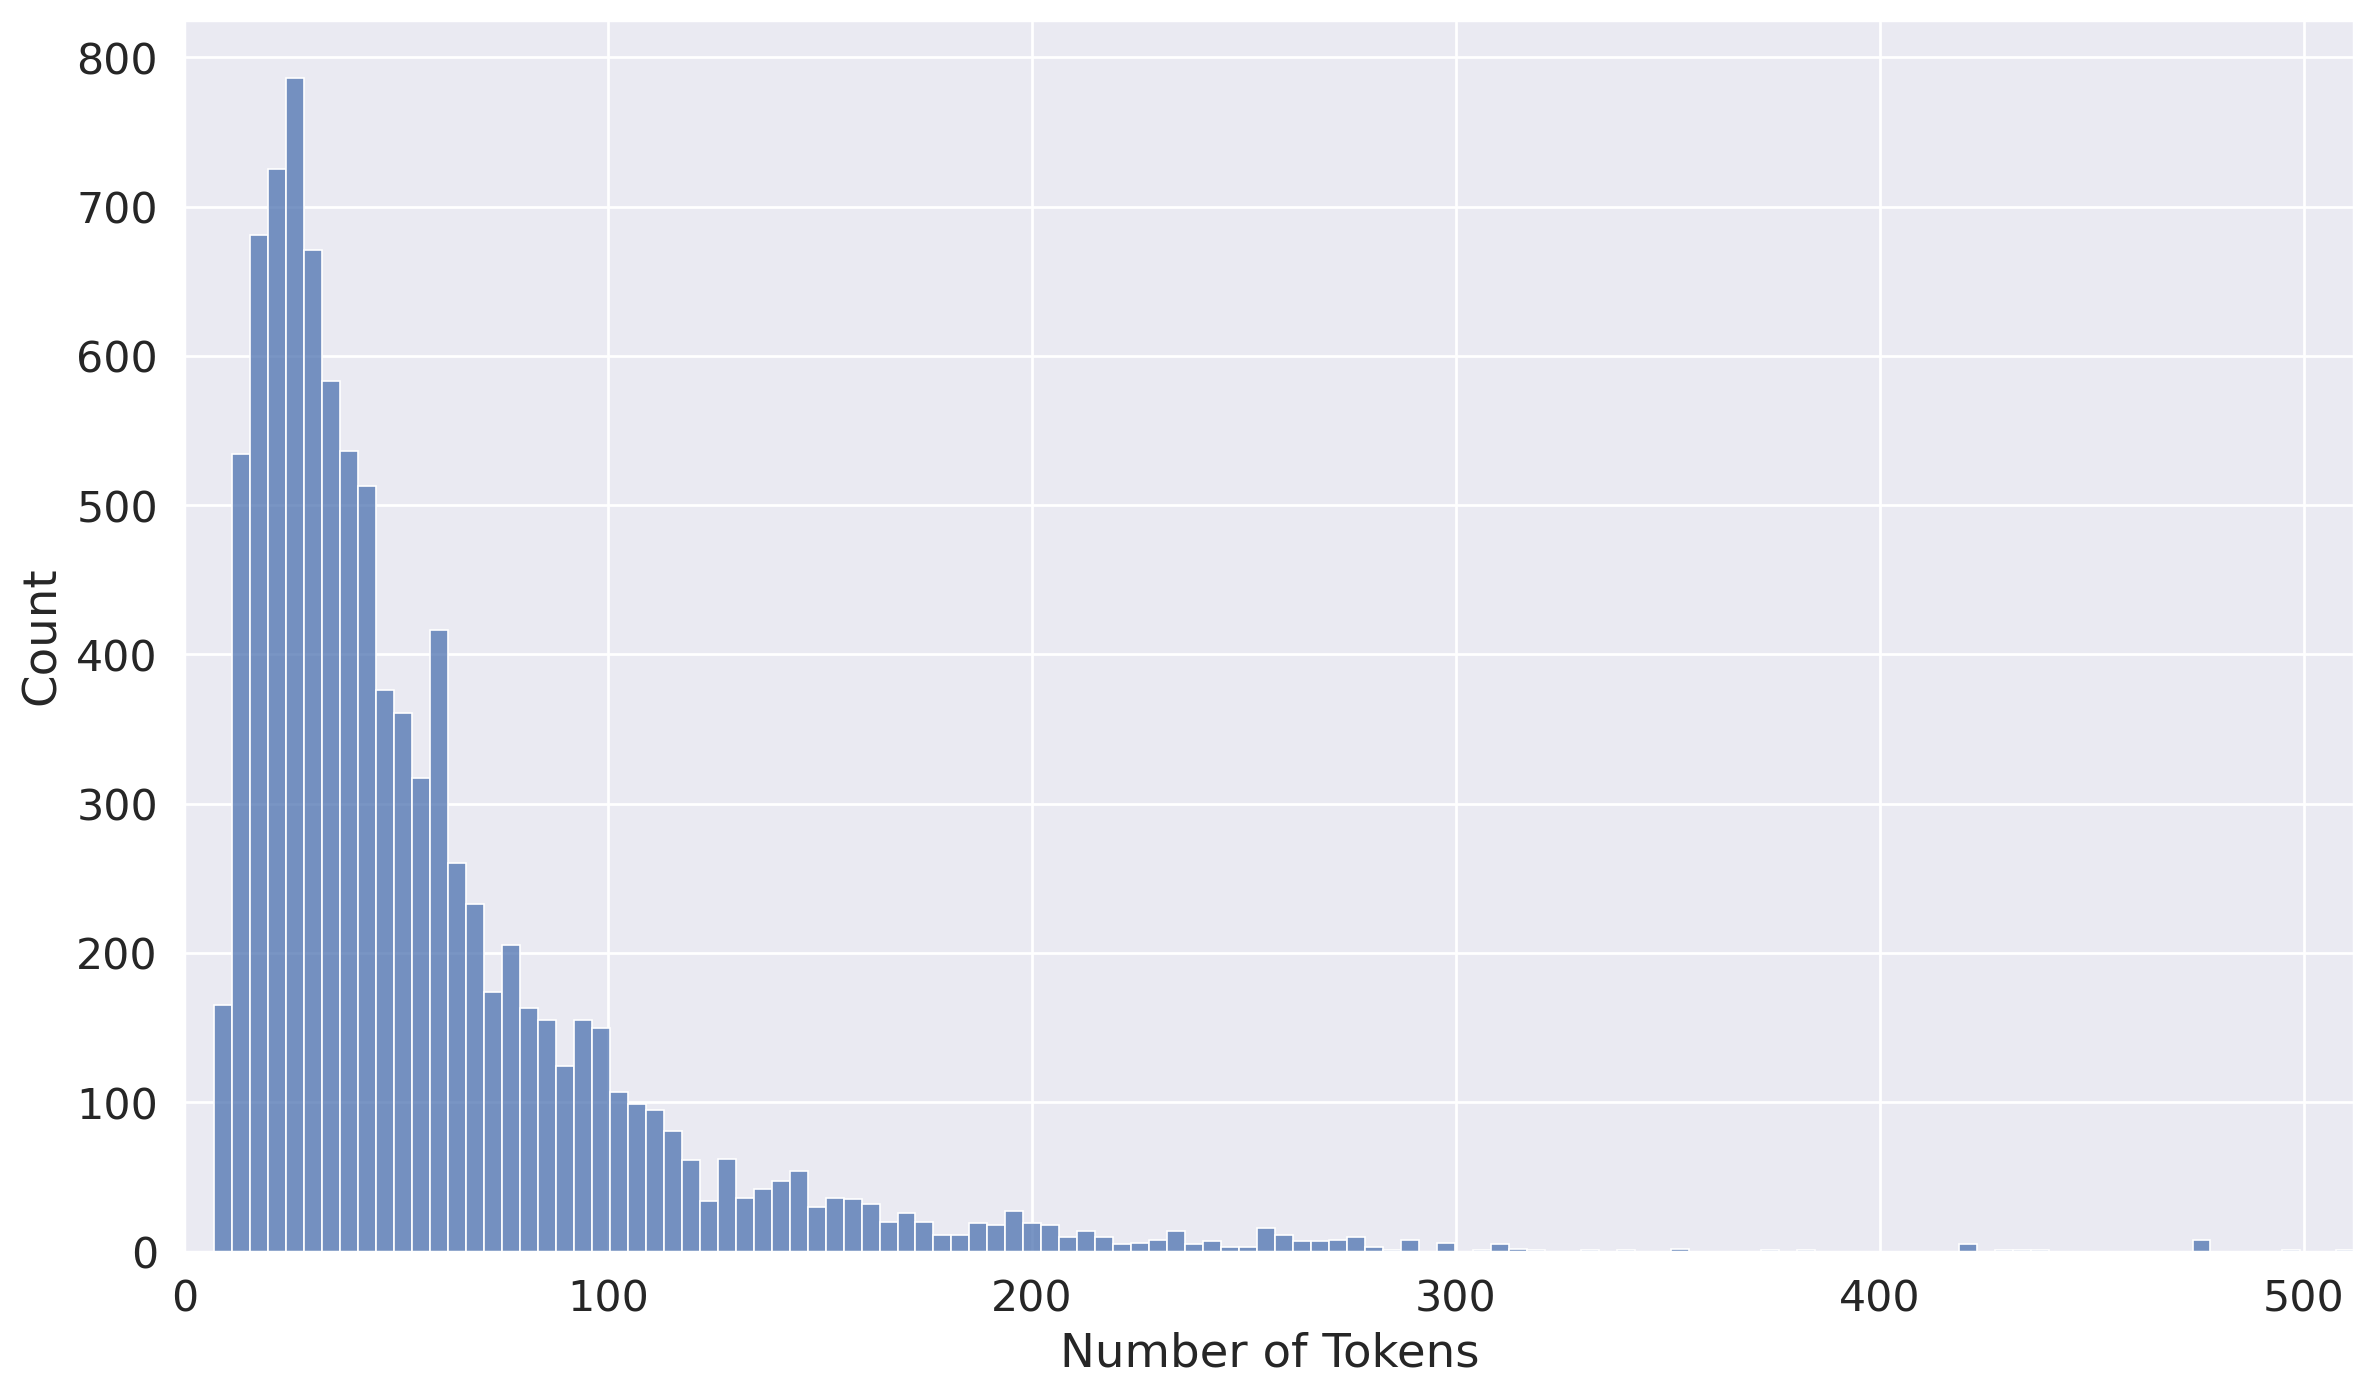

In [74]:
sns.set(font_scale=1.4)
plt.rcParams["figure.figsize"] = (14,8)
sns.histplot(token_lens)
plt.xlim([0, 512])
plt.xlabel('Number of Tokens')
plt.show()

#### Majority of the reviews seem to have less than 240 tokens

In [75]:
MAX_SEQ_LENGTH = 240

#### Split the dataset into train (70 %), validation (15%) and test (15%) sets

In [76]:
x_train, x_test, y_train, y_test = train_test_split(df['cleaned_reviews'],df.sentiment, test_size=0.3, random_state = 42, stratify=df.sentiment)
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.5, random_state = 42, stratify= y_test)

In [77]:
y_train = y_train.astype(int)
y_val = y_val.astype(int)
y_test = y_test.astype(int)

In [78]:

train_reviews = x_train.tolist()
val_reviews = x_val.tolist()
test_reviews = x_test.tolist()

### Create a sequence of token ids (input ids) for each review

In [79]:
# Train dataset
train_input_ids = [tokenizer.encode(train_reviews[i],add_special_tokens = True, max_length=MAX_SEQ_LENGTH, truncation=True) for i in range(0,len(train_reviews))]
# Val dataset
val_input_ids = [tokenizer.encode(val_reviews[i],add_special_tokens = True, max_length=MAX_SEQ_LENGTH, truncation=True) for i in range(0,len(val_reviews))]
# Test dataset
test_input_ids = [tokenizer.encode(test_reviews[i],add_special_tokens = True, max_length=MAX_SEQ_LENGTH, truncation=True) for i in range(0,len(test_reviews))]

### pad and truncate our sequences so that they all have the same length

In [80]:
from keras.preprocessing.sequence import pad_sequences    # Pad utility function to pad sequences to maximum length.

# Padding value: is optional, the default is 0.

# Train dataset
train_input_ids = pad_sequences(train_input_ids, maxlen=MAX_SEQ_LENGTH, dtype="long",
                          value=0, truncating="post", padding="post")

# Validation dataset
val_input_ids = pad_sequences(val_input_ids, maxlen=MAX_SEQ_LENGTH, dtype="long",
                          value=0, truncating="post", padding="post")

# Test dataset
test_input_ids = pad_sequences(test_input_ids, maxlen=MAX_SEQ_LENGTH, dtype="long",
                          value=0, truncating="post", padding="post")

### **Attention Masks**

In [81]:
# Create attention masks

# Train dataset
train_attention_masks = [[int(token_id > 0) for token_id in review]
                         for review in train_input_ids]
# dev dataset
val_attention_masks = [[int(token_id > 0) for token_id in review]
                         for review in val_input_ids]
# Test dataset
test_attention_masks = [[int(token_id > 0) for token_id in review]
                         for review in test_input_ids]

### **Convert all lists** of **inputs ids**, **labels** and **attention masks** into **torch tensors**

In [82]:
# input_ids
train_inputs = torch.tensor(train_input_ids)
val_inputs = torch.tensor(val_input_ids)
test_inputs = torch.tensor(test_input_ids)
# labels
train_labels = torch.tensor(y_train.values)
val_labels = torch.tensor(y_val.values)
test_labels = torch.tensor(y_test.values)
# attention masks
train_masks = torch.tensor(train_attention_masks)
val_masks = torch.tensor(val_attention_masks)
test_masks = torch.tensor(test_attention_masks)

### Create a **`DataLoader`** to **load** our **datasets**. 

In [83]:
batch_size = 16

# Create the DataLoader for our training set.
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set.
val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

# Create the DataLoader for our test set.
test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

In [84]:
# Number of classes / labels
n_classes = y_train.nunique()
n_classes

2

### **BertForSequenceClassification**

In [85]:
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # The 12-layer BERT model with an uncased vocab
    num_labels = 2, # For binary classification
    output_attentions = False, # Not to return attentions weights
    output_hidden_states = False, # Not to return all hidden-states
)


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


#### **Move** our model to the **GPU**

In [86]:
model = model.to(device)

### Finetuning our bert model by creating an optimizer

- **Batch size**: 16
- **Learning rate** (Adam):  3e-5
- **Number of epochs**: 2


In [87]:
epochs=2

optimizer=AdamW(model.parameters(),lr=3e-5)
total_steps=len(train_dataloader)*epochs

# Create the learning rate scheduler
scheduler=get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)
 # Define loss function and move it to GPU
loss_fn=nn.CrossEntropyLoss().to(device)

## **Training** our model and **validation**:

In [88]:
#calculating elapsed time
def format_time(elapsed):
    # Round to the nearest second
    elapsed_round = int(round(elapsed))
    # Format time in hh:mm:ss
    return str(datetime.timedelta(seconds = elapsed_round))

In [89]:
#calculating accuracy
def accuracy(preds, labels):
    preds = np.argmax(preds, axis=1).flatten()
    labels = labels.flatten()
    return np.sum(preds == labels) / len(labels)

### **Training** and **validation**


In [90]:
# Store for each epoch
loss_train_values = []
acc_train_values = []
loss_val_values = []
acc_val_values = []
for epoch in range(0,epochs):

        #             --- Train---

        # Perform forward pass over the training dataset
        print("\n Epoch {:}/{:} :".format(epoch+1,epochs))
        print('Training....')

        # Measure how long the training epoch takes
        t0 = time.time()
        # Reset total loss and accuracy for this epoch
        total_loss = 0
        total_acc = 0

        # Put the model in training mode
        model.train()

        # For each batch of training data
        for step, batch in enumerate(train_dataloader):
            # Update progress for each 100 steps
            if (step % 100==0) & (not step==0):
                # Calculate elapsed time in minutes
                elapsed = format_time((time.time()-t0))
                # Report progress
                print(' Batch {:>5,} of {:>5,}. Elapsed:{:}.'.format(step,len(train_dataloader),elapsed))

            # Unpack training batch from trainloader and move to GPU
            b_input_ids = batch[0].to(device)  # 0 - input ids tensor
            b_attention_mask = batch[1].to(device) # 1 - input masks tensor
            b_labels = batch[2].to(device) # 2 - labels tensor

            # Clear any previously calculated gradients in Pytorch before performing a backward pass
            model.zero_grad()

            # Output the results
            outputs = model(input_ids = b_input_ids, attention_mask = b_attention_mask, labels=b_labels) # Return tuple
            # Loss value from output
            loss = outputs.loss   # Loss

            # Update total loss
            total_loss += loss.item()

            preds = outputs.logits  # Output probabilities
            # Move logits and labels to CPU
            preds = preds.detach().cpu().numpy()
            label_ids = b_labels.to('cpu').numpy()

            # Calculate the accuracy for this batch
            tmp_train_accuracy = accuracy(preds, label_ids)

            # Accumulate the total accuracy
            total_acc += tmp_train_accuracy

            # Perform a backward pass to calculate gradients
            loss.backward()

            # To avoid exploding vanishing gradients problem, clip the norm of the gradients to 1.0
            torch.nn.utils.clip_grad_norm_(model.parameters(),1.0)

            # Update the parameters (weights)
            optimizer.step()

            # Update the learning rate
            scheduler.step()

        # Calculate the average loss over training data
        avg_total_loss = total_loss/len(train_dataloader)

        # Store the loss values
        loss_train_values.append(avg_total_loss)

        # Calculate the average accuracy over the training data
        avg_train_acc = total_acc / len(train_dataloader)

        # Store the accuracy values
        acc_train_values.append(avg_train_acc)

        print("")
        print("\nAverage training accuracy: {0:.2f}".format(avg_train_acc))

        print('Average training loss : {0:.2f}'.format(avg_total_loss))
        print('Training epoch took: {:}'.format(format_time(time.time()- t0)))

        #             --- VALIDATION ---


        # After each epoch perform validation to check model performance
        print('\n Running validation...')

        t0 = time.time()
        # Put model in evaluation mode
        model.eval()

        # Tracking variables
        total_eval_accuracy = 0
        total_eval_loss = 0

        # Unpack validation batch from trainloader and move to GPU
        for batch in val_dataloader:
            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)

            # Tell model not to compute gradients to save memory and accelerate validation
            with torch.no_grad():
                # Forward pass, calculate logit prediction
                 outputs = model(b_input_ids,
                                   token_type_ids=None,
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
            loss = outputs.loss
            logits = outputs.logits
            # Update total evaluation loss
            total_eval_loss += loss.item()

            # Move logits and labels to CPU
            logits = logits.detach().cpu().numpy()
            label_ids = b_labels.to('cpu').numpy()

            # Calculate the accuracy for this batch and accumulate it over all batches
            total_eval_accuracy += accuracy(logits, label_ids)

        # Compute the average accuracy over all of the batches
        avg_val_accuracy = total_eval_accuracy / len(val_dataloader)

        # Store the accuracy values
        acc_val_values.append(avg_val_accuracy)

        # Compute the average loss over all of the batches
        avg_val_loss = total_eval_loss / len(val_dataloader)

         # Store the loss values
        loss_val_values.append(avg_val_loss)

    # Measure how long the validation run took.
        validation_time = format_time(time.time() - t0)
        print("  Accuracy: {0:.2f}".format(avg_val_accuracy))
        print("  Validation Loss: {0:.2f}".format(avg_val_loss))
        print("  Validation took: {:}".format(validation_time))




 Epoch 1/2 :
Training....
 Batch   100 of   417. Elapsed:0:01:00.
 Batch   200 of   417. Elapsed:0:01:59.
 Batch   300 of   417. Elapsed:0:03:00.
 Batch   400 of   417. Elapsed:0:04:01.


Average training accuracy: 0.91
Average training loss : 0.24
Training epoch took: 0:04:11

 Running validation...
  Accuracy: 0.95
  Validation Loss: 0.14
  Validation took: 0:00:19

 Epoch 2/2 :
Training....
 Batch   100 of   417. Elapsed:0:01:01.
 Batch   200 of   417. Elapsed:0:02:02.
 Batch   300 of   417. Elapsed:0:03:02.
 Batch   400 of   417. Elapsed:0:04:03.


Average training accuracy: 0.98
Average training loss : 0.07
Training epoch took: 0:04:13

 Running validation...
  Accuracy: 0.97
  Validation Loss: 0.15
  Validation took: 0:00:19


**Plot validation accuracy after** the **completion** of **each epoch**:

In [91]:
df_acc = pd.DataFrame(acc_val_values,columns=['Accuracy'])

In [92]:
df_acc.index+=1

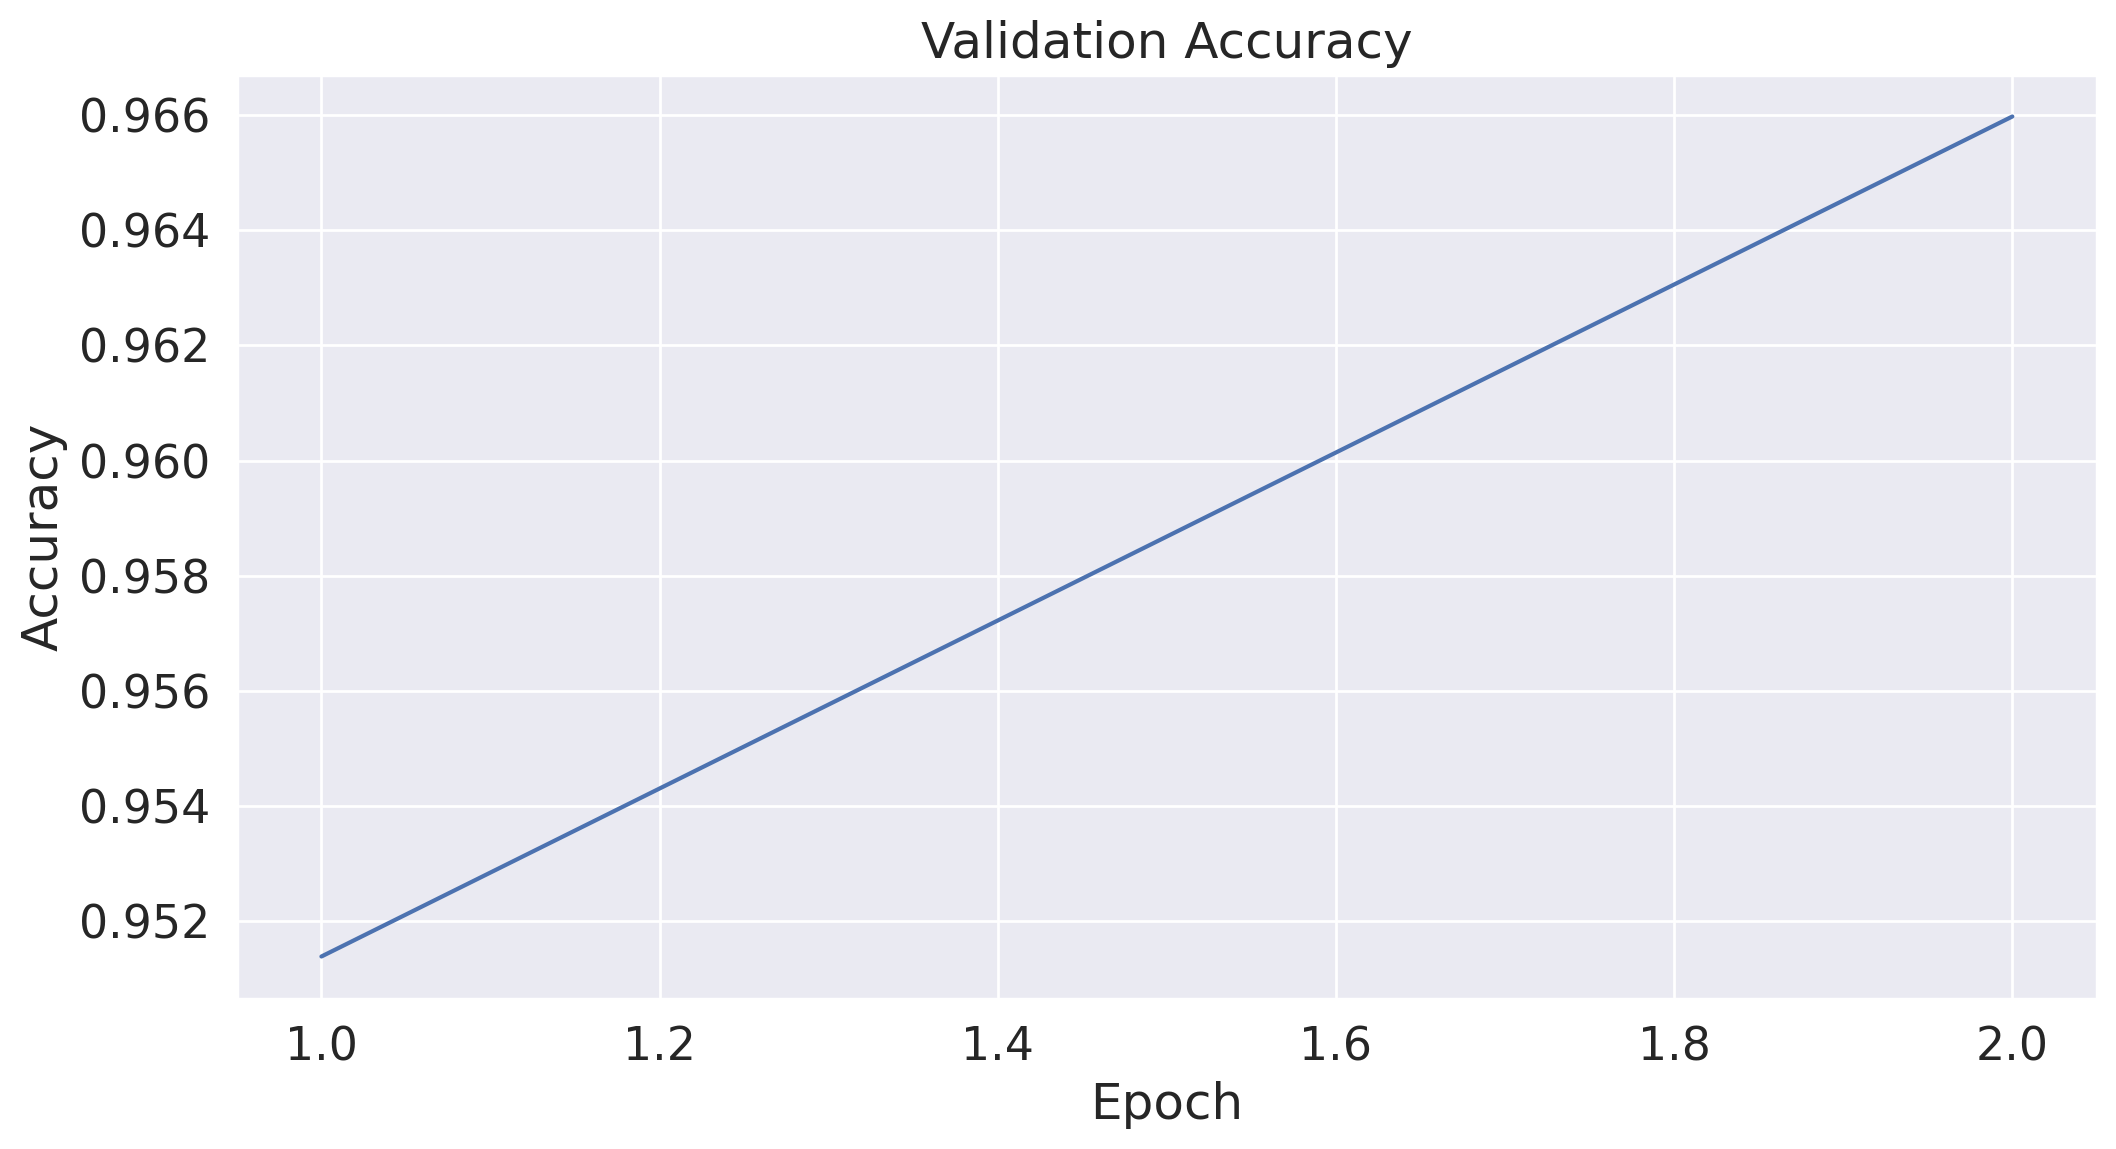

In [93]:
# Use plot styling from seaborn
sns.set(style='darkgrid')

# Increase the plot size and font size
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve
sns.lineplot(data=df_acc,x=df_acc.index,y=df_acc.Accuracy)

# Label the plot
plt.title("Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

plt.show()

**Plot validation loss after** the **completion** of **each epoch**:

In [94]:
df_loss = pd.DataFrame(loss_val_values,columns=['Loss'])

In [95]:
df_loss.index+=1

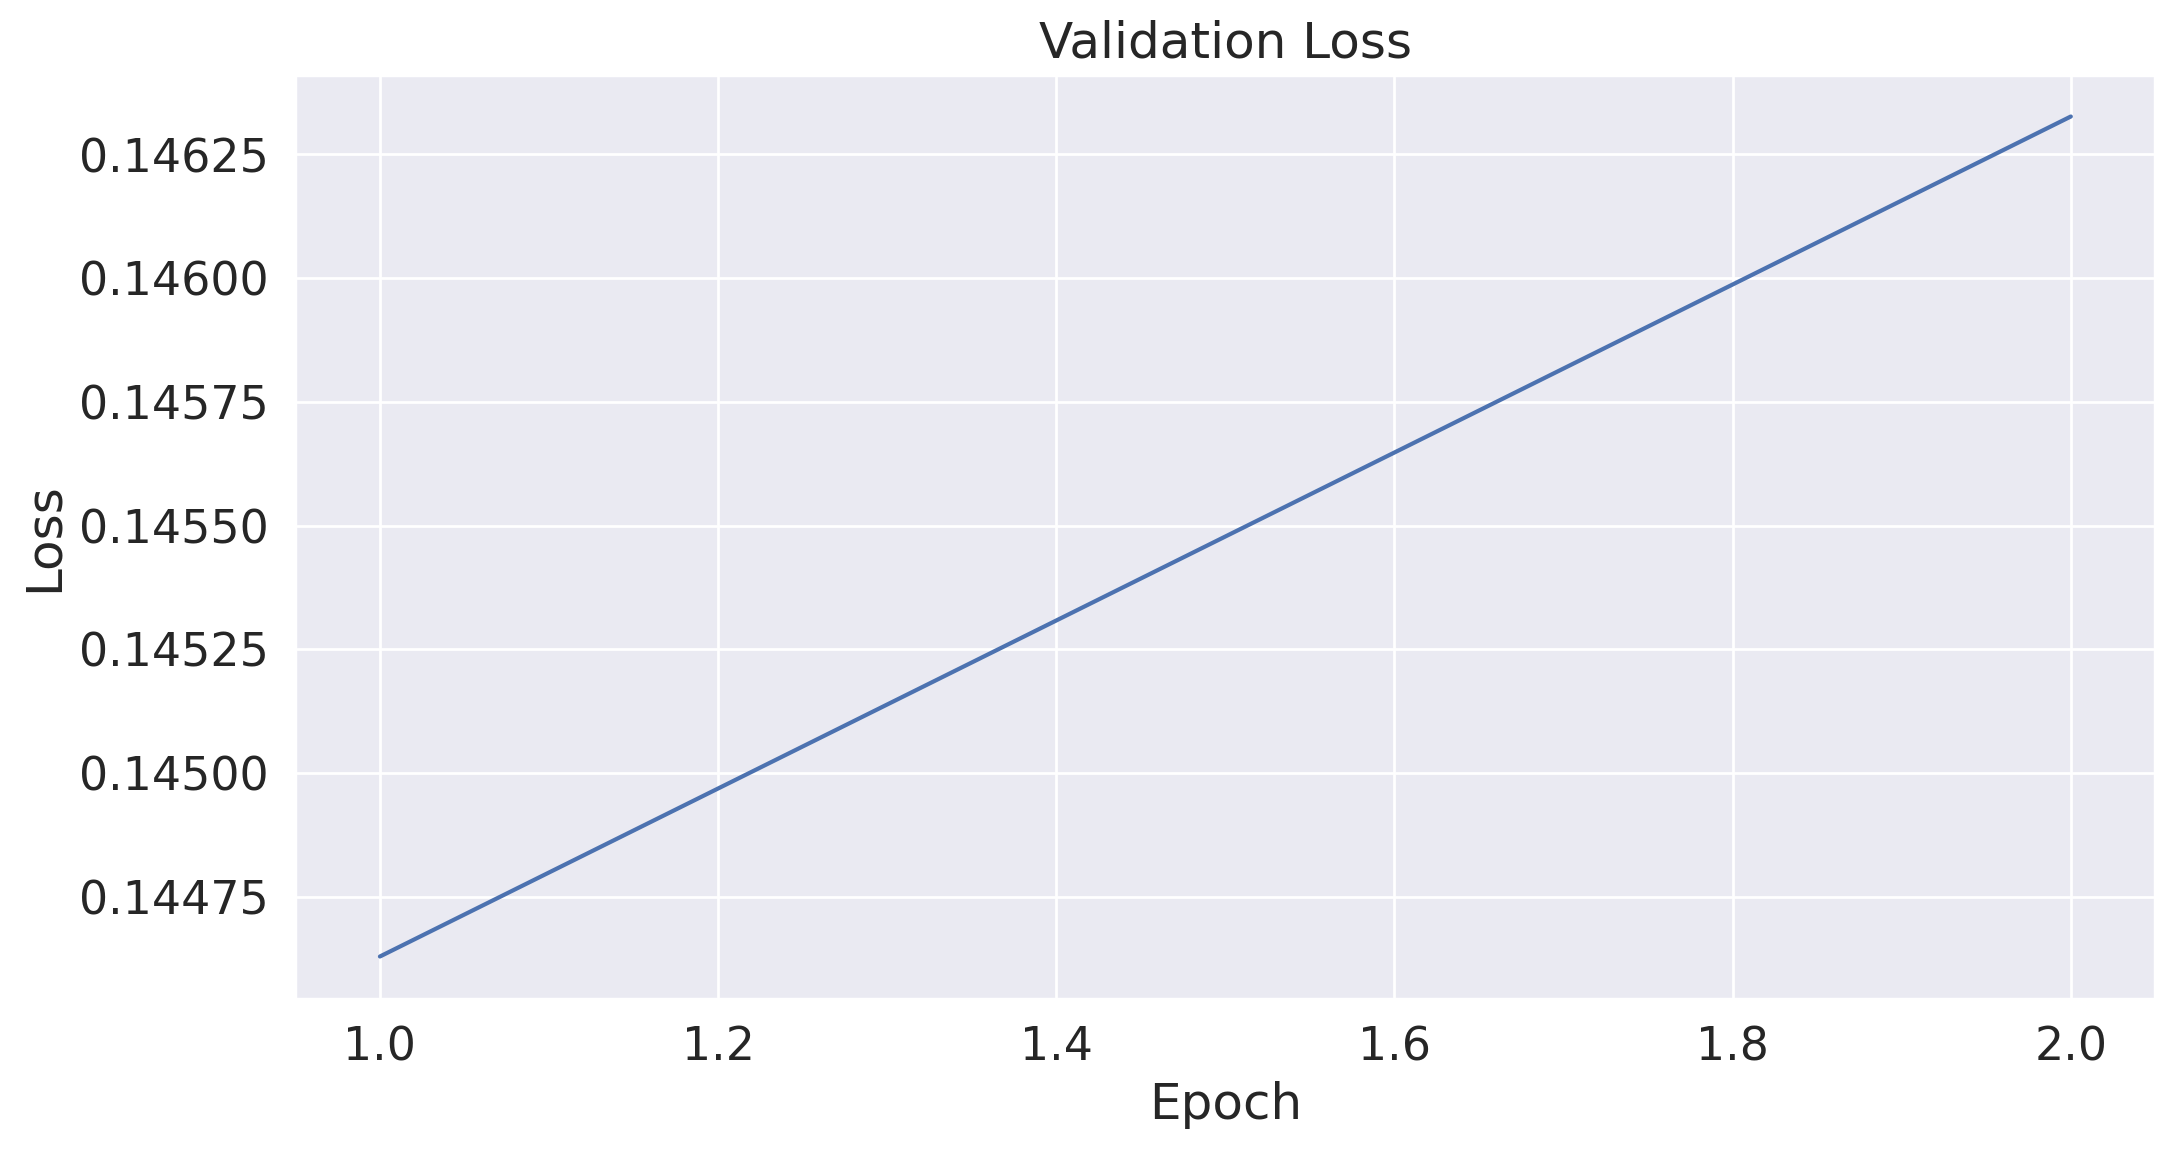

In [96]:
# Use plot styling from seaborn
sns.set(style='darkgrid')

# Increase the plot size and font size
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve
sns.lineplot(data=df_loss,x=df_loss.index,y=df_loss.Loss)

# Label the plot
plt.title("Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

#### **Predicting** on **test set**


In [97]:
# Put model in evaluation mode
model.eval()

# Tracking variables
predictions , true_labels = [], []

# Predict test data
for batch in test_dataloader:
    # Move batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack inputs from test dataloader
    b_input_ids, b_attention_mask, b_labels = batch
    # Tell model not to compute gradients to save memory and accelerate validation
    with torch.no_grad():
        # Forward pass, calculate logit prediction
        outputs = model(input_ids=b_input_ids, attention_mask=b_attention_mask)
    # logits are class probabilities and get them from outputs
    logits = outputs[0]

    # Store predictions and true labels
    predictions.extend(logits.tolist())
    true_labels.extend(b_labels.tolist())

print('Done')

Done


#### **Convert predictions** to **tensor**

In [98]:
preds = torch.tensor(predictions)

#### **Apply softmax** on **predictions**

In [99]:
import torch.nn.functional as F

preds = F.softmax(preds,dim=1)

#### **Convert to numpy arrays**

In [100]:
preds = np.array(preds)
true_labels = np.array(true_labels)

#### **Function** for **Heatmap of confusion matrix** for **test data**

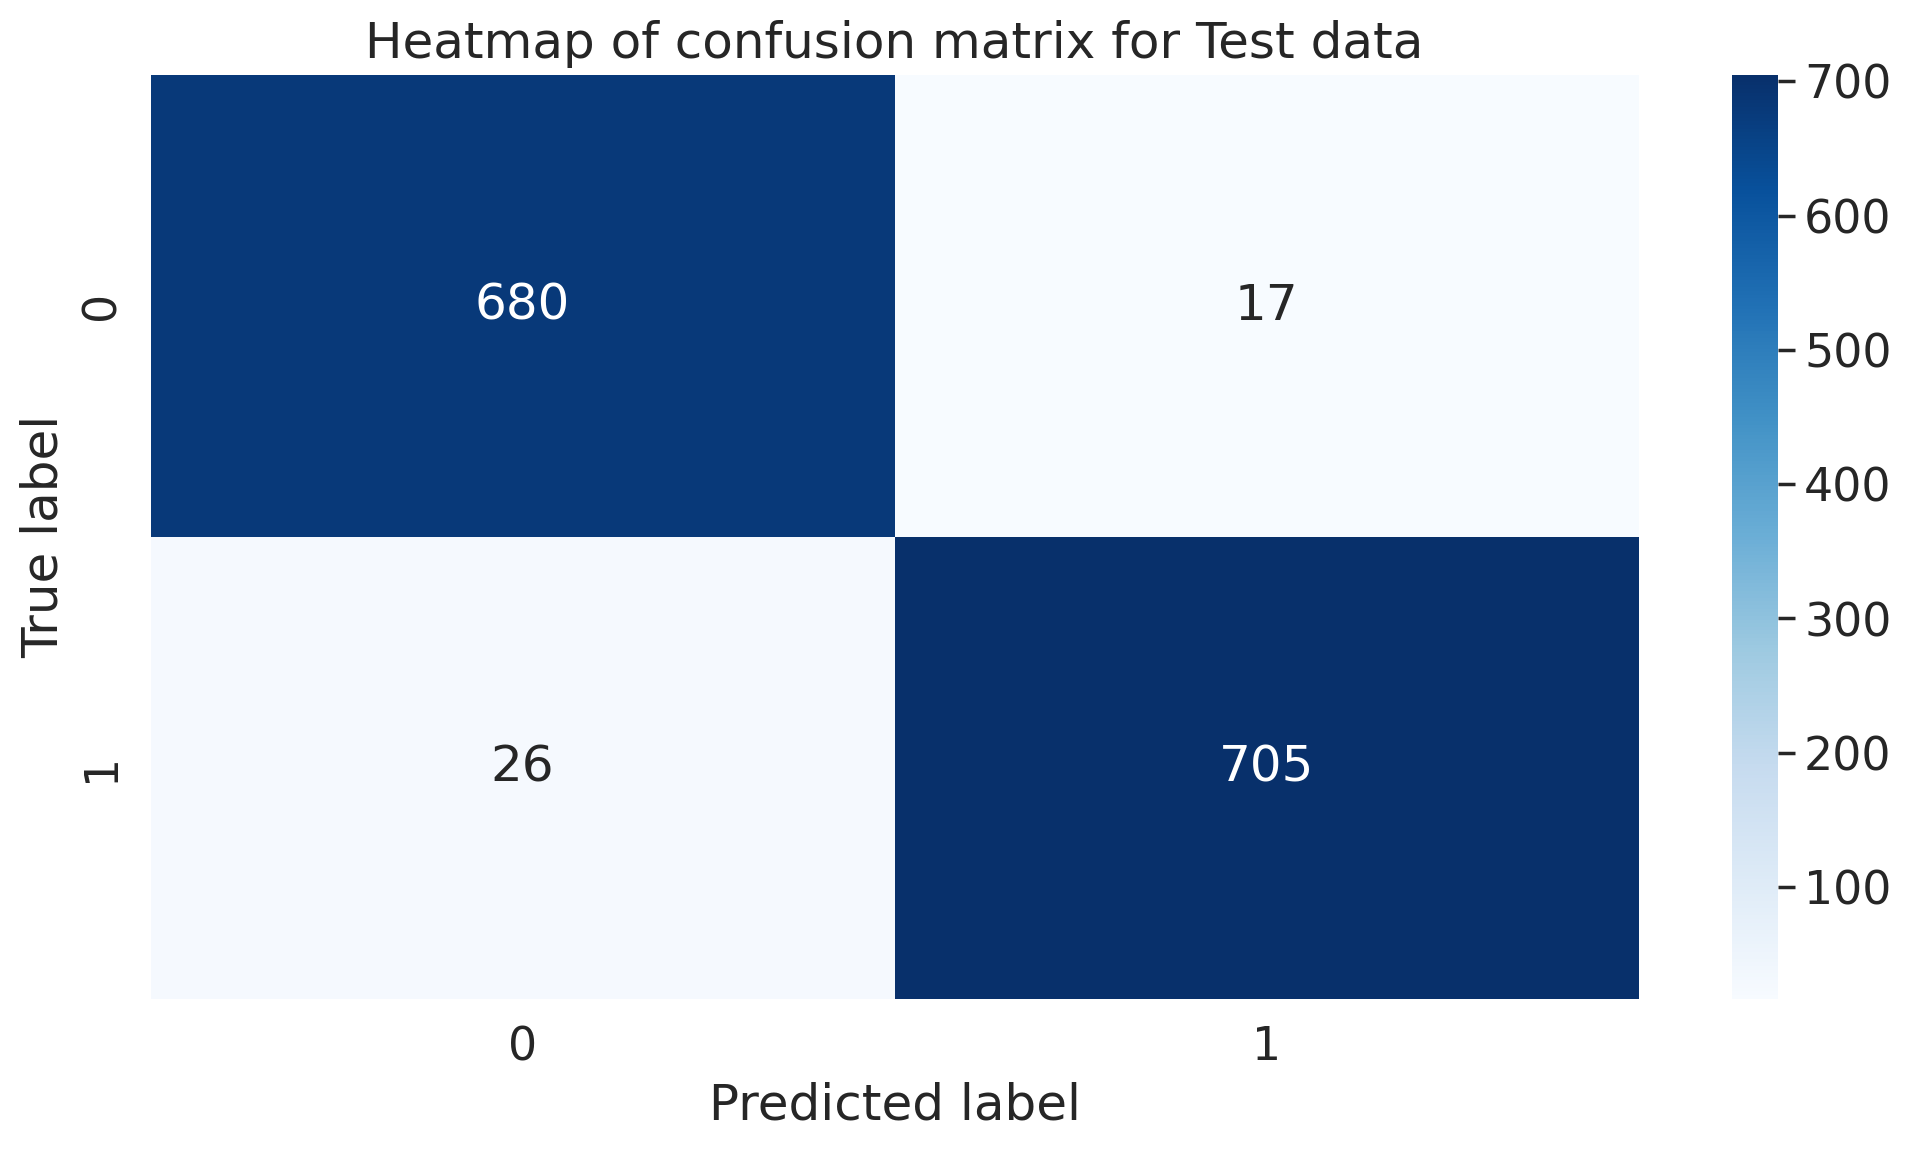

In [101]:
def evaluate(y_test, predictions):
    cf_matrix = confusion_matrix(true_labels, preds.argmax(1))
    sns.heatmap(cf_matrix, annot = True, fmt = 'd',cmap="Blues")
    plt.title('Heatmap of confusion matrix for Test data')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
evaluate(true_labels, preds.argmax(1))

#### **Classification Report**

In [102]:
class_report= classification_report(true_labels, preds.argmax(1), digits=3)
print(class_report)

              precision    recall  f1-score   support

           0      0.963     0.976     0.969       697
           1      0.976     0.964     0.970       731

    accuracy                          0.970      1428
   macro avg      0.970     0.970     0.970      1428
weighted avg      0.970     0.970     0.970      1428
